In [ ]:
#Partially used QuantConnect bull option strategy
from AlgorithmImports import *
from quantconnect.api import Api
class BullPutSpreadStrategy(QuantConnect): 
    def Initialize(self) -> None:
        #Start with 500,000
        self.SetCash(500000) 
        self.SetStartDate(2022, 1, 1)
        self.SetEndDate(2023, 1, 10)

        option = self.AddOption("ALLY", Resolution.Minute)
        self.symbol = option.Symbol
        option.SetFilter(self.UniverseFunc)

    def UniverseFunc(self, universe: OptionFilterUniverse) -> OptionFilterUniverse:
        return universe.IncludeWeeklys().Strikes(-9, 5).Expiration(timedelta(0), timedelta(31))

    def OnData(self, slice: Slice) -> None:
        if self.Portfolio.Invested: return

        # Pull option chain
        chain = slice.OptionChains.get(self.symbol, None)
        if not chain: return

        # Pull furthest to future strategy (sort then get the first one after reversing it)
        expiry = sorted(chain, key = lambda x: x.Expiry, reverse=True)[0].Expiry
        
        # Select the put Option contracts with the furthest expiry
        puts = [i for i in chain if i.Expiry == expiry and i.Right == OptionRight.Put]
        if len(puts) == 0: return

        # Select the ITM and OTM contract strikes from the remaining contracts
        put_strikes = sorted([x.Strike for x in puts])
        otm_strike = put_strikes[0]
        itm_strike = put_strikes[-1]

        option_strategy = OptionStrategies.BearPutSpread(self.symbol, itm_strike, otm_strike, expiry)

        self.Buy(option_strategy, 1)

In [5]:
!jt -t oceans16


**Below my strategy can be seen slowly gaining money due to its safe return, we can make returns higher simply by decreasing the distance in sorted set of furthest out options to increase implied volatility and collect more premium** (2022 Jan 1, 2023 Jan 10)

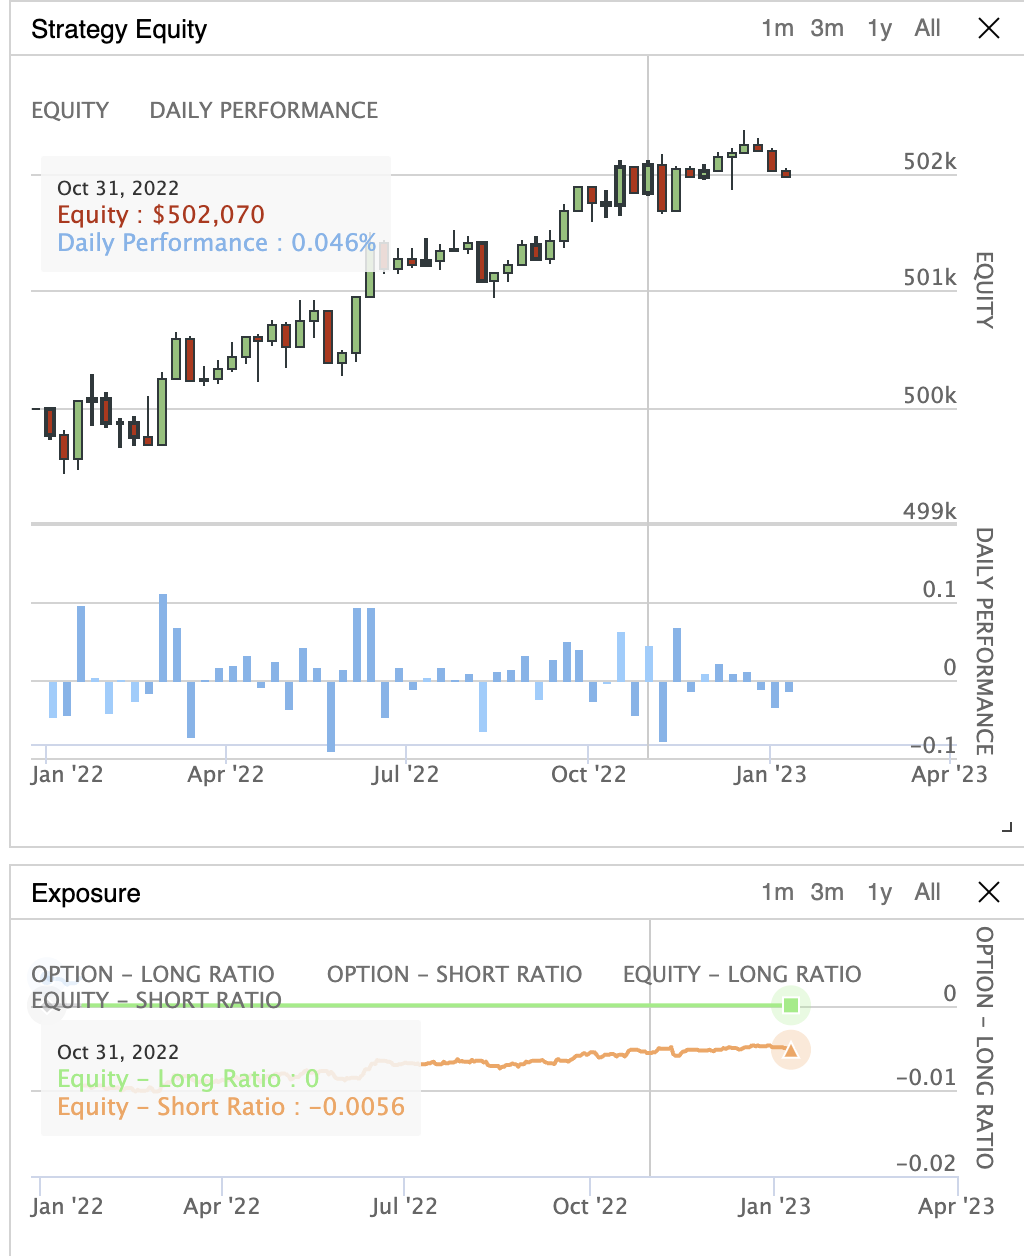

In [6]:
display.Image("/Users/ammad/Desktop/mig/ALLY-Strategy-2.png")